In [2]:
from __future__ import division 

import gym
import numpy as np
import random
import tensorflow as tf 
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import scipy.misc
import os
import sys
%matplotlib inline

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ..., 
       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255,

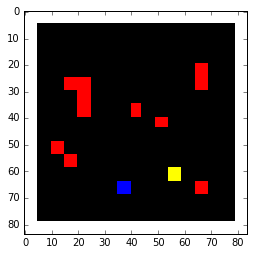

In [3]:
from gridworld_v04 import gameEnv
env = gameEnv(partial=False, size=15)
env.renderEnv()

In [4]:
class Qnetwork():
    def __init__(self, h_size, name = "main"):
        self.h_size = h_size
        self.net_name = name
        
        self.build_network()
        
    def build_network (self): #// h_size is the number of activation of conv4 
        #The network recieves a frame from the game, flattened into an array.
      
    #    self.scalarInput = tf.placeholder(shape=[None,84*84*3], dtype=tf.float32)
    #    self.imageIn = tf.reshape(self.scalarInput, shape=[-1,84,84,3])
        
        with tf.variable_scope(self.net_name):
            # Input(return value of env.reset) dimension
            # self.dimX = env.?

            self.dimX = len(env.objects) * 2
            self.dimY = env.actions

            # Dimensions of each layer 
            self.nInputLayer = self.dimX
#             self.nHidden1 = h_size
#             self.nHidden2 = (int)(h_size / 2 )
#             self.nHidden3 = (int)(h_size / 4)
            self.nHidden1 = 256
            self.nHidden2 = 256
            self.nHidden3 = 256
            self.nOutputLayer = self.dimY

            self.input = tf.placeholder(shape=[None, self.dimX], dtype=tf.float32)
            self.output = tf.placeholder(shape=[None, self.dimY], dtype=tf.float32)

            # Weights of each layer
            self.W = {
                'W1': self.init_weight("W1", [self.nInputLayer, self.nHidden1]),
                'W2': self.init_weight("W2", [self.nHidden1, self.nHidden2]),
                'W3': self.init_weight("W3", [self.nHidden2, self.nHidden3]),
                'W4': self.init_weight("W4", [self.nHidden3, self.nOutputLayer])
            }

            # Bias of each layer
            self.b = {
                'b1': self.init_bias(self.nHidden1),
                'b2': self.init_bias(self.nHidden2),
                'b3': self.init_bias(self.nHidden3),
                'b4': self.init_bias(self.nOutputLayer)
            }

            # If we need,
            self.dropProb = 0.0


            self.hidden1 = tf.nn.relu(tf.add(tf.matmul(self.input, self.W['W1']), self.b['b1']))
            # self.hidden1 = tf.nn.dropout(self.hidden1, self.dropProb)

            self.hidden2 = tf.nn.relu(tf.add(tf.matmul(self.hidden1, self.W['W2']), self.b['b2']))
            # self.hidden2 = tf.nn.dropout(self.hidden2, self.dropProb)

            self.hidden3 = tf.nn.relu(tf.add(tf.matmul(self.hidden2, self.W['W3']), self.b['b3']))
            # self.hidden3 = tf.nn.dropout(self.hidden3, self.dropProb)

            self.output = tf.add(tf.matmul(self.hidden3, self.W['W4']), self.b['b4'])

            """
            self.conv1 = slim.conv2d(inputs=self.imageIn,
                                     num_outputs=32,
                                     kernel_size=[8,8],
                                     stride=[4,4],
                                     padding='VALID', 
                                     biases_initializer = None)

            self.conv2 = slim.conv2d(inputs=self.conv1,
                                     num_outputs=64,
                                     kernel_size=[4,4],
                                     stride=[2,2],
                                     padding='VALID',
                                     biases_initializer = None)

            self.conv3 = slim.conv2d(inputs=self.conv2,
                                     num_outputs=64,
                                     kernel_size=[3,3],
                                     stride=[1,1],
                                     padding='VALID',
                                     biases_initializer = None)

            self.conv4 = slim.conv2d(inputs=self.conv3,
                                     num_outputs=h_size,
                                     kernel_size=[7,7],
                                     stride=[1,1],
                                     padding='VALID',
                                     biases_initializer = None)
             """

            #We take the output from the final convolutional layer and split it into separated terms: advantage & value
            # I think the input dimension of our env is 1-dim 
            self.streamAC, self.streamVC = tf.split(self.output, 2, 1)
            self.streamA = slim.flatten(self.streamAC)
            self.streamV = slim.flatten(self.streamVC)

            xavier_init = tf.contrib.layers.xavier_initializer()

            self.AW = tf.Variable(xavier_init([self.dimY//2, env.actions]))
            self.VM = tf.Variable(xavier_init([self.dimY//2, 1]))

            self.Advantage = tf.matmul(self.streamA, self.AW)
            self.Value = tf.matmul(self.streamV, self.VM)

            #Then combine to obtain the final Q-value //why substract mean from Advantage?
            self.Qout = self.Value + tf.subtract(self.Advantage, tf.reduce_mean(self.Advantage,axis=1, keep_dims=True))
            #self.Qout = self.output
            self.predict = tf.argmax(self.Qout, 1)

            #Obtain the loss by taking the sum of squares difference between the target and predicted Q values
            self.targetQ = tf.placeholder(shape=[None], dtype=tf.float32)
            self.actions = tf.placeholder(shape=[None], dtype=tf.int32)
            self.actions_onehot = tf.one_hot(self.actions, env.actions, dtype=tf.float32) #// env.actions is probably number of actions

            self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)

            self.td_error = tf.square(self.targetQ - self.Q)
            self.loss = tf.reduce_mean(self.td_error)

            self.trainer = tf.train.AdamOptimizer(learning_rate=0.001)
            self.updateModel = self.trainer.minimize(self.loss)    
            
    def init_weight(self, name, shape):
        return tf.get_variable(name=name, shape=shape, initializer=tf.contrib.layers.xavier_initializer())

    def init_bias(self, n):
        return tf.Variable(tf.random_normal([n]))

In [5]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
        
    def add(self, experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience) + len(self.buffer)) - self.buffer_size] = []
        self.buffer.extend(experience)#// remove the necesary entries to make place for new experience
        
    def sample(self, size):
        return np.reshape(np.array(random.sample(self.buffer, size)),[size,5]) # buffer is experience tuple (size 4) plus "done" signal

In [6]:
def processState(states):
    return np.reshape(states,[84*84*3])

In [7]:
def updateTargetGraph(tfVars, tau):
    total_vars = len(tfVars)
    op_holder = []
    
    for idx,var in enumerate(tfVars[0:total_vars//2]): #// select the first half of the variables (the one that belong to the action choosing net) 
        op_holder.append(
            tfVars[idx+total_vars//2].assign(
                (var.value()*tau)+((1-tau)*tfVars[idx+total_vars//2].value())))#// basically take values from the primary net and modify then slithly with values from the second net, then return then for later use of model update 
    
    return op_holder

def updateTarget(op_holder, sess):
    for op in op_holder:
        sess.run(op)  

In [8]:
def get_copy_var_ops(*, dest_scope_name="target", src_scope_name="main"):
    op_holder = []
    
    src_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=src_scope_name)
    dest_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=dest_scope_name)
    
    for src_var, dest_var in zip(src_vars, dest_vars):
        op_holder.append(dest_var.assign(src_var.value()))
        
    return op_holder

In [12]:
#Set all the training parameters
batch_size = 32 #Number of experiences to use for each training step
update_freq = 5 #Frequency of a train step

y = .99 #Discount factor on the target Q-values

startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
#anneling_steps = 10000. #Number of training steps to decrease the explorarion parameter e 
anneling_steps = 10000

#num_episodes = 3*10000 #Number of episodes of the game environmet on which to train the network
num_episodes = 10000
#pre_train_steps = 10000 #Number of random action steps before training begins
pre_train_steps = 10000

#max_epLength = 100 #Maximun allowed length of a game episode
max_epLength = 500

load_model = False #Wheter to load a saved model
path = "./log" #Directory for checkpoints
#log_path = "./dqn_logs/logs" #Directory for logs

h_size = 512 #Number of activations of final conv layer

tau = 0.001 #Rate of update of target network values onto the primary network

#f = open(log_path,'w')

In [10]:
tf.reset_default_graph()

#Network instances
mainQN = Qnetwork(h_size, name="main")
targetQN = Qnetwork(h_size, name="target")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

trainables = tf.trainable_variables()
targetOps = updateTargetGraph(trainables, tau)

myBuffer = experience_buffer()

#Set the rate of random action decrease
e = startE
stepDrop = (startE - endE)/anneling_steps

#Create lists to contain total reward and steps per episode
jList = []
rList = []
total_steps = 0

#Create path for checkpoints
if not os.path.exists(path):
    os.makedirs(path)

In [10]:
with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
    for i in range(num_episodes):
        if i%100 == 0:
            print("\n=====" + "Episode " + str(i) + "start =====" )
        episodeBuffer = experience_buffer()
        #Reset environment and get first new observation
        s = env.reset()
        # s = processState(s)
        d = False
        rAll = 0
        j = 0
        #The Q-Network
        while j < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trial.
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            # e = 0.0001
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,4)
            else:
                a = sess.run(mainQN.predict,feed_dict={mainQN.input:[s]})[0]
                      
            s1,r,d = env.step(a)
            #print(s1, r, d)
            #s1 = processState(s1)
            total_steps += 1
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5])) #Save the experience to our episode buffer.
            
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop
                
                if total_steps % (update_freq) == 0:
                    trainBatch = myBuffer.sample(batch_size) #Get a random batch of experiences.
                    #Below we perform the Double-DQN update to the target Q-values
                    Q1 = sess.run(mainQN.predict,feed_dict={mainQN.input:np.vstack(trainBatch[:,3])})
                    Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.input:np.vstack(trainBatch[:,3])})
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    #Update the network with our target values.
                    _ = sess.run(mainQN.updateModel, \
                        feed_dict={mainQN.input:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1]})
                    
                    updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
            rAll += r
            s = s1
            
            if d == True:

                break
        
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        #Periodically save the model. 
        if i % 1000 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.cptk')
            print("Saved Model")
        if len(rList) % 10 == 0:
            print(total_steps,np.mean(rList[-10:]), e)
    saver.save(sess,path+'/model-'+str(i)+'.cptk')
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")


=====Episode 0start =====
Saved Model
4428 -75.6 1
8935 -74.8 1
13438 -66.1 0.6905799999998814
18132 -44.5 0.2681199999998625
23132 -25.9 0.09999999999985551
27905 -14.1 0.09999999999985551
32406 -15.9 0.09999999999985551
36909 -22.6 0.09999999999985551
41421 -15.8 0.09999999999985551
46421 -27.3 0.09999999999985551

=====Episode 100start =====
51421 -11.9 0.09999999999985551
54933 -10.6 0.09999999999985551
59437 -14.6 0.09999999999985551
64437 -18.9 0.09999999999985551
69437 -33.3 0.09999999999985551
73940 -22.4 0.09999999999985551
78940 -17.8 0.09999999999985551
83940 -14.1 0.09999999999985551
88940 -14.7 0.09999999999985551
93532 -12.3 0.09999999999985551

=====Episode 200start =====
98039 -11.1 0.09999999999985551
102974 -16.3 0.09999999999985551
107974 -15.0 0.09999999999985551
112974 -14.6 0.09999999999985551
117478 -11.4 0.09999999999985551
122478 -23.5 0.09999999999985551
127478 -24.8 0.09999999999985551
131980 -11.0 0.09999999999985551
136029 -9.5 0.09999999999985551
140779 -

403363 3.8 0.09999999999985551

=====Episode 2400start =====
403500 3.8 0.09999999999985551
403890 1.1 0.09999999999985551
404074 3.7 0.09999999999985551
404380 3.8 0.09999999999985551
404637 4.0 0.09999999999985551
404860 3.9 0.09999999999985551
405087 3.8 0.09999999999985551
405289 3.8 0.09999999999985551
405553 3.9 0.09999999999985551
405712 3.8 0.09999999999985551

=====Episode 2500start =====
405949 3.8 0.09999999999985551
406185 4.0 0.09999999999985551
406340 2.2 0.09999999999985551
406622 3.9 0.09999999999985551
406763 3.9 0.09999999999985551
407191 3.6 0.09999999999985551
407315 3.8 0.09999999999985551
407632 3.8 0.09999999999985551
408018 3.7 0.09999999999985551
408289 4.0 0.09999999999985551

=====Episode 2600start =====
408569 3.6 0.09999999999985551
408641 4.0 0.09999999999985551
408792 3.9 0.09999999999985551
409072 3.6 0.09999999999985551
409279 3.7 0.09999999999985551
409597 3.7 0.09999999999985551
409841 4.0 0.09999999999985551
410121 3.3 0.09999999999985551
410534 3.1 

464835 3.9 0.09999999999985551
465060 3.7 0.09999999999985551
465279 3.7 0.09999999999985551
465424 3.9 0.09999999999985551
465549 4.0 0.09999999999985551
465713 3.9 0.09999999999985551
465854 3.9 0.09999999999985551
465978 3.9 0.09999999999985551
466136 4.0 0.09999999999985551
466333 3.8 0.09999999999985551

=====Episode 4900start =====
466448 3.9 0.09999999999985551
466582 3.7 0.09999999999985551
466751 3.9 0.09999999999985551
466838 4.0 0.09999999999985551
467067 3.9 0.09999999999985551
467257 3.7 0.09999999999985551
467514 3.2 0.09999999999985551
467755 3.5 0.09999999999985551
467851 4.0 0.09999999999985551
467918 4.0 0.09999999999985551

=====Episode 5000start =====
Saved Model
468025 3.9 0.09999999999985551
468157 3.9 0.09999999999985551
468403 3.5 0.09999999999985551
468608 4.0 0.09999999999985551
468691 3.9 0.09999999999985551
468841 3.8 0.09999999999985551
469062 3.9 0.09999999999985551
469349 3.6 0.09999999999985551
469573 3.9 0.09999999999985551
469790 3.3 0.0999999999998555

507249 4.0 0.09999999999985551
507603 3.5 0.09999999999985551
507771 3.7 0.09999999999985551
507881 3.9 0.09999999999985551
508071 3.7 0.09999999999985551
508340 3.4 0.09999999999985551
508426 4.0 0.09999999999985551
508561 4.0 0.09999999999985551
508691 3.9 0.09999999999985551

=====Episode 7300start =====
508815 3.9 0.09999999999985551
508949 3.8 0.09999999999985551
509110 3.8 0.09999999999985551
509327 3.9 0.09999999999985551
509450 3.9 0.09999999999985551
509603 3.9 0.09999999999985551
509741 3.6 0.09999999999985551
509866 3.9 0.09999999999985551
510042 3.5 0.09999999999985551
510323 3.8 0.09999999999985551

=====Episode 7400start =====
510459 3.9 0.09999999999985551
510571 4.0 0.09999999999985551
510750 3.8 0.09999999999985551
510860 4.0 0.09999999999985551
510979 4.0 0.09999999999985551
511064 4.0 0.09999999999985551
511291 3.8 0.09999999999985551
511397 3.8 0.09999999999985551
511506 4.0 0.09999999999985551
511690 3.9 0.09999999999985551

=====Episode 7500start =====
511797 3.9 

544555 3.6 0.09999999999985551
544963 3.1 0.09999999999985551
545072 4.0 0.09999999999985551
545192 3.8 0.09999999999985551
545343 3.9 0.09999999999985551
545516 3.8 0.09999999999985551
545634 3.9 0.09999999999985551

=====Episode 9700start =====
545859 4.0 0.09999999999985551
546053 3.7 0.09999999999985551
546297 4.0 0.09999999999985551
546494 4.0 0.09999999999985551
546614 3.8 0.09999999999985551
546789 3.6 0.09999999999985551
546962 4.0 0.09999999999985551
547131 3.7 0.09999999999985551
547329 3.9 0.09999999999985551
547501 3.4 0.09999999999985551

=====Episode 9800start =====
547640 4.0 0.09999999999985551
547786 3.9 0.09999999999985551
547947 3.9 0.09999999999985551
548097 3.8 0.09999999999985551
548166 4.0 0.09999999999985551
548296 3.9 0.09999999999985551
548448 3.8 0.09999999999985551
548620 3.9 0.09999999999985551
548728 4.0 0.09999999999985551
548953 4.0 0.09999999999985551

=====Episode 9900start =====
549048 2.3 0.09999999999985551
549286 3.7 0.09999999999985551
549599 3.3 

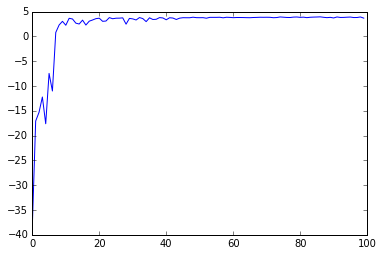

In [11]:
rMat = np.resize(np.array(rList), [len(rList)//100,100])
rMean = np.average(rMat, 1)
plt.plot(rMean)

------------------------------------

## Testing the network performance

This first piece of code aims to make a step by step walkthrough the game to see what actions is taken
For some reason the actor is performing a single action. Need to debug.

In [12]:
#Create lists to contain total reward and steps per episode
jList_t = []
rList_t = []
total_steps_t = 0

In [13]:
sess = tf.InteractiveSession()

In [14]:
ckpt = tf.train.get_checkpoint_state(path)
saver.restore(sess, ckpt.model_checkpoint_path)    

INFO:tensorflow:Restoring parameters from ./log1/model-9999.cptk


[2017-06-06 14:34:48,725] Restoring parameters from ./log1/model-9999.cptk


In [15]:
#Reset environment and get the first new observation
s = env.reset_for_testing()
#s = env.reset()
#s = processState(s)
d = False
rAll_t = 0
j_t = 0        

Action: 0
Reward: 4 , Done: True
End of training episode


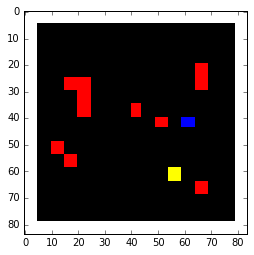

In [223]:
#Choose an action by greedily picking from the Q-net
a = sess.run(mainQN.predict, feed_dict={mainQN.input:[s]})[0]# //the extra [0] takes the value of the sing-entry array that Main1.predict returns
print ("Action: %d" % a)
#s1, r, d = env.step(a)
s1, r, d = env.step_for_testing(a)
print ("Reward: %d , Done: %s" % (r, d))
#plt.imshow(s1, interpolation = "nearest")
env.renderEnv()
#s1 = processState(s1)#// flatten the return frame
total_steps_t += 1
                        
rAll_t += r
s = s1



if d == True:
    print("End of training episode")
    jList_t.append(j_t)
    rList_t.append(rAll_t) 
             
    if len(rList_t) % 10 == 0:
        accumR = np.mean(rList_t[-10:])  
        log = str(total_steps_t) +"\t"+ str(accumR)  
        print(log)             

In [170]:
sess.close()

Test the actor in an automatic way. The issue is the same, the actor chooses the same action constantly

In [15]:
#Create lists to contain total reward and steps per episode
jList_t = []
rList_t = []
total_steps_t = 0

# Test setting parameters
load_model = True
num_test_episodes = 5000

#Create lists to contain total reward and steps per episode
with tf.Session() as sess:
    
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess, ckpt.model_checkpoint_path)
    
    for i in range(num_test_episodes):
        
        #Reset environment and get the first new observation
        s = env.reset_for_testing()
        #s = processState(s)
        d = False
        rAll_t = 0
        j_t = 0
        
        #Q-Network
        while j_t < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trail
            j_t+=1
            
            #Choose an action by greedily picking from the Q-net
            a = sess.run(mainQN.predict, feed_dict={mainQN.input:[s]})[0]# //the extra [0] takes the value of the sing-entry array that Main1.predict returns
                
            s1, r, d = env.step_for_testing(a)
           #s1 = processState(s1)#// flatten the return frame
            total_steps_t += 1
                        
              
            rAll_t += r
            s = s1
                
            if d == True:
                break
                        
        jList_t.append(j_t)
        rList_t.append(rAll_t)
            
        print(rAll_t)
        
        if len(rList_t) % 10 == 0:
            accumR = np.mean(rList_t[-10:])
            log = str(total_steps_t) +"\t"+ str(accumR) 
            #print(log)
            #f.write(log)
                
    
final_log = "Percent of sucessful episodes: " + str(sum(rList_t)/num_test_episodes) + "%"
print(final_log)

Loading Model...
INFO:tensorflow:Restoring parameters from ./log/model-9999.cptk


[2017-06-08 06:43:12,623] Restoring parameters from ./log/model-9999.cptk


4.0
4.0
-1.0
4.0
4.0
4.0
-1.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
-1.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
-1.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
-1.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
-1.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
-1.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
-1.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
-1.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
-1.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
-1.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
-1.0
4.0
-1.0
-1.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
-1.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
-1.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
-1.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
-1.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
-1.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
-1.0
4.0
-1.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
-1.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
-1.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4

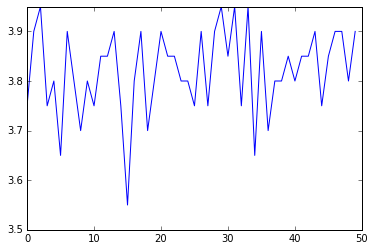

In [16]:
rMat_t = np.resize(np.array(rList_t), [len(rList_t)//100,100])
rMean_t = np.average(rMat_t, 1)
plt.plot(rMean_t)

---------------------------------------------

## Test Random Actor

In [35]:
# Test setting parameters for random actor
num_test_episodes = 5000

#Create lists to contain total reward and steps per episode
jList_t = []
rList_t = []
total_steps_t = 0

_,_ = env.checkGoal()

with tf.Session() as sess:
    sess.run(init)
        
    for i in range(num_test_episodes):
        
        d = False
        rAll_t = 0
        j_t = 0
        
        while j_t < max_epLength: #If the agent takes longer than 50 moves to reach either of the blocks, end the trail
            j_t += 1
            
            a = np.random.randint(0,4)
                
            s1, r, d = env.step(a)
            s1 = processState(s1)#// flatten the return frame
            total_steps_t += 1
                      
            rAll_t += r
            s = s1
                
            if d == True:
                break
                        
        
        jList_t.append(j_t)
        rList_t.append(rAll_t)
            
        if len(rList_t) % 10 == 0:
            accumR = np.mean(rList_t[-10:])
            log = str(total_steps_t) +"\t"+ str(accumR) 
            print(log)
                           
    
final_log = "Percent of sucessful test episodes: " + str(sum(rList_t)/num_test_episodes) + "%"
print(final_log)

62	-0.6
140	-1.0
248	-1.0
367	-0.8
427	-0.8
564	-0.6
607	-0.6
730	-0.9
806	-0.8
891	-0.6
1013	-1.0
1129	-0.8
1209	-0.4
1307	-0.6
1406	-0.9
1508	-0.6
1562	-1.0
1608	-1.0
1751	-0.8
1836	-0.8
1912	-0.6
2003	-0.6
2101	-0.8
2194	-1.0
2268	-1.0
2314	-0.8
2394	-0.6
2477	-1.0
2575	-1.0
2671	-1.0
2753	-0.8
2828	-0.8
2936	-0.8
3003	-1.0
3082	-0.6
3173	-0.6
3318	-0.6
3429	-0.8
3575	-0.5
3740	-0.4
3828	-0.2
3975	-0.8
4082	-1.0
4133	-0.8
4202	-0.8
4267	-0.6
4386	-0.8
4505	-0.4
4626	-0.4
4693	-1.0
4745	-0.8
4792	-0.8
4860	-0.6
4974	-0.9
5031	-0.6
5066	-0.8
5207	-0.8
5313	-0.6
5410	-0.8
5513	-1.0
5582	-0.8
5683	-0.6
5811	-1.0
5865	-0.8
5954	-0.8
6006	-0.2
6121	-1.0
6246	-0.8
6300	-0.8
6394	-0.6
6516	-0.7
6616	-0.8
6679	-0.4
6758	-0.6
6842	-0.4
6887	-0.4
6955	-0.8
7006	-0.6
7111	-0.8
7225	-0.4
7268	-1.0
7397	-0.8
7455	-0.6
7529	-1.0
7564	-0.6
7643	-0.8
7731	-0.8
7886	-1.0
7990	-0.6
8073	-0.8
8120	-0.6
8186	-1.0
8213	-0.8
8283	-0.4
8357	-0.8
8417	-0.8
8510	-1.0
8649	-1.0
8715	-0.4
8798	-0.8
8884	-0.6
8

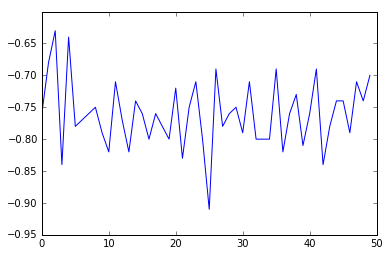

In [34]:
rMat_t = np.resize(np.array(rList_t), [len(rList_t)//100,100])
rMean_t = np.average(rMat_t, 1)
plt.plot(rMean_t)